# Deep Learning for solving Argument Mining task

Main argument mining task:

- Argumentative fragment detection
- Argument component classification
- Argumentative relation recognition

## Task 1 - Argumentative fragment detection

### Loading the data

In [ ]:
# Mount Drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

In [ ]:
def load_sst_data(path: str):
  data = pd.read_csv(path)
  return data

sst_home = "drive/My Drive/Datasets/dm-2019/dm-2019-annotated.csv"
dataset = load_sst_data(sst_home)
dataset

,sent_id,sent_text,sent_label1,sent_label2,sent_label3
0,109-0-0,Limpieza de graffitis y remodelación de aluche,YES,CLAIM,NONE
1,109-0-0,Los vecinos de Aluche vemos día tras día como ...,YES,CLAIM,NONE
2,109-0-0,Los vecinos de Aluche vemos día tras día como ...,YES,CLAIM,NONE
3,109-0-1,"Graffitis y basura por todas partes, aceras ro...",YES,CLAIM,NONE
4,109-17276-0,No a los ruidos.,YES,CLAIM,NONE
...,...,...,...,...,...
3249,89-78258-1,Os recuerdo que España es el país de la OCDE d...,YES,PREMISE,EXPLANATION
3250,89-78258-2,La desigualdad en España avanza a un ritmo que...,YES,PREMISE,EXPLANATION
3251,89-78258-3,La pobreza y la exclusión en España han aument...,NO,SPAM,NONE
3252,89-78258-4,"Por otra lado, estamos a la espera de que nos ...",NO,SPAM,NONE


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def split_data(df, target_column, test_size=0.2, validation_size=0.1, random_state=None):

    # Split the data into a temporary train set and test/validation set
    train, temp = train_test_split(df, test_size=(test_size + validation_size), stratify=df[target_column], random_state=random_state)

    # Split the temp set into validation and test sets
    test, validation = train_test_split(temp, test_size=validation_size / (test_size + validation_size), stratify=temp[target_column], random_state=random_state)

    return train, validation, test

In [ ]:
label_column = "sent_label1"
label_dict = {"NO": 0, "YES": 1}

t1_data = dataset[["sent_text", label_column]]
t1_data = t1_data.replace({label_column: label_dict})

training_set, dev_set, test_set = split_data(t1_data, target_column=label_column, test_size=0.1, validation_size=0.1, random_state=42)

In [ ]:
type(training_set["sent_text"])

pandas.core.series.Series

Validation of stratified split:

In [ ]:
# Shuffle dataset
training_set = shuffle(training_set)
dev_set = shuffle(dev_set)
test_set = shuffle(test_set)

# Obtain text and label vectors
train_texts = training_set["sent_text"]
train_labels = training_set[label_column]

dev_texts = dev_set["sent_text"]
dev_labels = dev_set[label_column]

test_texts = test_set["sent_text"]
test_labels = test_set[label_column]


print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

Training size: 2603
Dev size: 326
Test size: 325


In [ ]:
print(f"Training classes:\n{train_labels.value_counts() / len(train_labels)}")

Training classes:
0    0.551287
1    0.448713
Name: sent_label1, dtype: float64


In [ ]:
print(f"Dev classes:\n{dev_labels.value_counts() / len(dev_labels)}")

Dev classes:
0    0.552147
1    0.447853
Name: sent_label1, dtype: float64


In [ ]:
print(f"Test classes:\n{test_labels.value_counts() / len(test_labels)}")

Test classes:
0    0.550769
1    0.449231
Name: sent_label1, dtype: float64


### Installing and seting up the Transformers library

In [ ]:
import tensorflow as tf

## for replicability of results
tf.random.set_seed(2)

In [ ]:
# https://blog.tensorflow.org/2019/11/hugging-face-state-of-art-natural.html
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00


Once the transformers library is installed, we can use it directly just creating three object of two classes:

- The tokenizer class
- The model class

The contextualized model in Spanish that we are going to use is BETO: https://github.com/dccuchile/beto

- HuggingFace cased model: https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased
- HuggingFace uncased model: https://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased

In [ ]:
from transformers import TFBertForSequenceClassification, BertTokenizer

hf_model_name = "dccuchile/bert-base-spanish-wwm-cased"
model = TFBertForSequenceClassification.from_pretrained(hf_model_name)
tokenizer = BertTokenizer.from_pretrained(hf_model_name)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next we will define two helper function to 1) extract features from the tokenizer (`convert_examples_to_features`) and 2) convert the features to `tf.data.Dataset` object class (`convert_features_to_tf_dataset`). `tf.data.Dataset` is a convinient API that helps managing and iterating in efficient way the input and output data of the model.  For more information you can check the API in tensorflow web page: https://www.tensorflow.org/api_docs/python/tf/data/Dataset.

In [ ]:
from transformers import InputFeatures

def convert_examples_to_features(texts, labels):
  labels = list(labels)
  batch_encoding = tokenizer.batch_encode_plus(texts, max_length=128, padding='longest')

  features = []
  for i in range(len(texts)):
      inputs = {k: batch_encoding[k][i] for k in batch_encoding}

      feature = InputFeatures(**inputs, label=labels[i])
      features.append(feature)

  for i, example in enumerate(texts[:5]):
      print("*** Example ***")
      print("text: %s" % (example))
      print("features: %s" % features[i])

  return features

def convert_features_to_tf_dataset(features):
  def gen():
      for ex in features:
          yield ({
              "input_ids": ex.input_ids,
              "attention_mask": ex.attention_mask,
              "token_type_ids": ex.token_type_ids
              }, ex.label)

  output_types = ({
      "input_ids": tf.int32,
      "attention_mask": tf.int32,
      "token_type_ids": tf.int32
      }, tf.int32)

  output_shapes = ({
      "input_ids": tf.TensorShape([None]),
      "attention_mask": tf.TensorShape([None]),
      "token_type_ids": tf.TensorShape([None])
      }, tf.TensorShape([]))

  dataset = tf.data.Dataset.from_generator(gen, output_types, output_shapes)
  return dataset

Model hyper-params:

In [ ]:
batch_size = 16
num_epochs = 3

Let's preprocess the training and development sets. Note that we use the `tf.data.Dataset` API to set the batch size to 16.

In [ ]:
train_features = convert_examples_to_features(train_texts, train_labels)
train_dataset = convert_features_to_tf_dataset(train_features)

dev_features = convert_examples_to_features(dev_texts, dev_labels)
dev_dataset = convert_features_to_tf_dataset(dev_features)

train_dataset = train_dataset.shuffle(100).batch(batch_size)
dev_dataset = dev_dataset.batch(batch_size)

*** Example ***
text: Al igual que estamos reclamando la remunicipalización de determinados servicios públicos, demandamos también la remunicipalización de un derecho básico como es el comer que muchas personas en nuestra ciudad no pueden ejercer por falta de medios económicos.
features: InputFeatures(input_ids=[4, 1403, 2581, 1038, 2527, 5406, 1156, 1030, 10268, 2739, 2919, 1008, 6416, 2287, 5481, 1017, 6290, 1305, 1447, 1030, 10268, 2739, 2919, 1008, 1049, 2199, 10882, 1184, 1058, 1040, 2073, 1038, 3119, 1858, 1036, 2367, 1903, 1084, 2016, 8481, 1096, 3389, 1008, 3342, 6156, 1009, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# Take one bacth of 16 examples
instance = list(train_dataset.take(1).as_numpy_iterator())
print(instance)

[({'input_ids': array([[    4,  2358,  1038, ...,     1,     1,     1],
       [    4,  1584,  1734, ...,     1,     1,     1],
       [    4,  1198,  6194, ...,     1,     1,     1],
       ...,
       [    4, 18732,  1038, ...,     1,     1,     1],
       [    4,  1412,  5199, ...,     1,     1,     1],
       [    4,  1198, 20536, ...,     1,     1,     1]], dtype=int32), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)}, array([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0], dtype=int32))]


### Understanding the tokenizer

In [ ]:
sentence1 = train_texts.iloc[0]

# Tokenize sentence
sentence1_tokenized = tokenizer.tokenize(sentence1)
print('0. INPUT SENTENCE: {}'.format(sentence1))
print('1. TOKENIZED SENTENCE: {}'.format(sentence1_tokenized))

# Add Special tokens
sentence1_tokenized_with_special_tokens = ['[CLS]'] + sentence1_tokenized + ['[SEP]']
print('2. ADD [CLS], [SEP]: {}'.format(sentence1_tokenized_with_special_tokens))
sentence1_ids = tokenizer.convert_tokens_to_ids(sentence1_tokenized_with_special_tokens)

# Convert to ids
print('3. SENTENCE IDS: {}'.format(sentence1_ids))

0. INPUT SENTENCE: Al igual que estamos reclamando la remunicipalización de determinados servicios públicos, demandamos también la remunicipalización de un derecho básico como es el comer que muchas personas en nuestra ciudad no pueden ejercer por falta de medios económicos.
1. TOKENIZED SENTENCE: ['Al', 'igual', 'que', 'estamos', 'reclam', '##ando', 'la', 'remun', '##icip', '##alización', 'de', 'determinados', 'servicios', 'públicos', ',', 'demanda', '##mos', 'también', 'la', 'remun', '##icip', '##alización', 'de', 'un', 'derecho', 'básico', 'como', 'es', 'el', 'comer', 'que', 'muchas', 'personas', 'en', 'nuestra', 'ciudad', 'no', 'pueden', 'ejercer', 'por', 'falta', 'de', 'medios', 'económicos', '.']
2. ADD [CLS], [SEP]: ['[CLS]', 'Al', 'igual', 'que', 'estamos', 'reclam', '##ando', 'la', 'remun', '##icip', '##alización', 'de', 'determinados', 'servicios', 'públicos', ',', 'demanda', '##mos', 'también', 'la', 'remun', '##icip', '##alización', 'de', 'un', 'derecho', 'básico', 'como', 

### Fine-tune BETO as Sentence Classifier

In [ ]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train and evaluate using tf.keras.Model.fit()
history = model.fit(train_dataset, epochs=num_epochs, validation_data=dev_dataset)

Epoch 1/3
163/163 [==============================] - 199s 731ms/step - loss: 0.5528 - accuracy: 0.7165 - val_loss: 0.5106 - val_accuracy: 0.7393
Epoch 2/3
163/163 [==============================] - 109s 670ms/step - loss: 0.3438 - accuracy: 0.8552 - val_loss: 0.7042 - val_accuracy: 0.7086
Epoch 3/3
163/163 [==============================] - 111s 684ms/step - loss: 0.1370 - accuracy: 0.9501 - val_loss: 0.9543 - val_accuracy: 0.7331


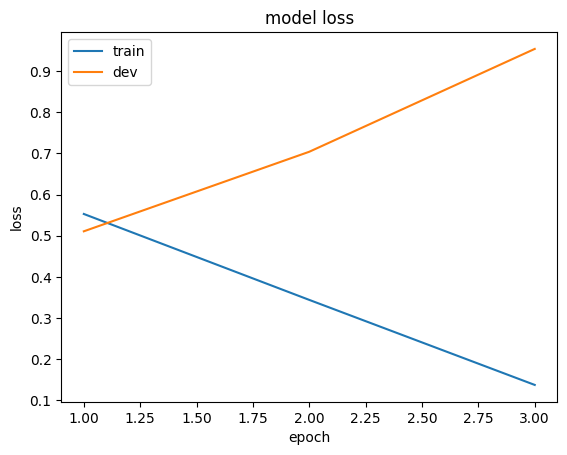

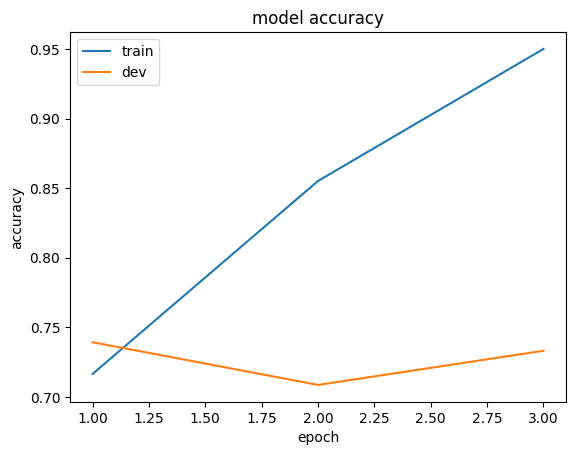

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# summarize history for accuracy
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

### Testing out model

Once the model is fine-tuned for sentiment analysis we could evaluate it on the test set. In this we need to tokenized and convert to ids the input too.

In [ ]:
test_features = convert_examples_to_features(test_texts, test_labels)
test_dataset = convert_features_to_tf_dataset(test_features)

*** Example ***
text: La página puede ayudaros avaluar lo que os supone un trasto.
features: InputFeatures(input_ids=[4, 1198, 5075, 1499, 2400, 1011, 19148, 22575, 1114, 1038, 2821, 5152, 1049, 2131, 1071, 1009, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
test_dataset = test_dataset.batch(batch_size)
instances = list(test_dataset.take(1).as_numpy_iterator())
instances

[({'input_ids': array([[    4,  1198,  5075, ...,     1,     1,     1],
          [    4,  5391,  1017, ...,     1,     1,     1],
          [    4,  5233,  1058, ...,     1,     1,     1],
          ...,
          [    4, 22469,  1311, ...,     1,     1,     1],
          [    4,  2638,  1734, ...,     1,     1,     1],
          [    4,  1125,  1240, ...,     1,     1,     1]], dtype=int32),
   'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0],
          ...,
          [1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
   'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=int32)},
  array([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0], dtype=int32))]

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

21/21 [==============================] - 4s 186ms/step - loss: 0.7844 - accuracy: 0.7508
Loss: 0.7844487428665161
Accuracy: 0.7507692575454712


### Serialize and save model

In [ ]:
# Serialize model to JSON

model_home = "drive/My Drive/Datasets/dm-2019/models/"
model_json = model.to_json()
with open(model_home + "am-t1-beto-model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights(model_home + "am-t1-beto-model.h5")

---

You can check how much GPU/CPU you are using in your colab sessions.

In [ ]:
# memory footprint support libraries/code
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn't guaranteed
gpu = GPUs[0]

def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print('GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=20ac0d13dc16922e4cd98928274ef614d04154aaed02394060bb31675e79d6f2
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
Gen RAM Free: 8.5 GB  I Proc size: 4.3 GB
GPU RAM Free: 6300MB | Used: 8801MB | Util  57% | Total 15360MB
